In [1]:
from __future__ import division
import numpy as np
import os
import pandas as pd
from Shrad_modules import *
from mpl_toolkits.basemap import cm
import calendar
import time
from my_plot_module import *
from theil_sen import *
from mk_test import *
import matplotlib.gridspec as gridspec
import time

In [39]:
def my_plotmap2(var, lats, lons, lat_min, lat_max, lat_int, lon_min, lon_max, lon_int, cmap, cbmin, cbmax, plottype, levels, labels_1, labels_2, col_under, col_higher, extend,area_thresh=10000):
    #importing required modules               
    from mpl_toolkits.basemap import Basemap
    import numpy as np
    import matplotlib as mpl
    if plottype == 'mesh':
        lonres = (lons.max()-lons.min())/(len(lons)-1)
        latres = (lats.max()-lats.min())/(len(lats)-1)
        lats = lats - 0.5*latres
        lons = lons - 0.5*lonres
    elif plottype == 'contour':
        pass
    elif plottype == 'color':
        pass
    else:
        raise ValueError('{}: Not a valid option for plottype'.
                         format(plottype))

    m = Basemap(projection='cyl', llcrnrlat=lat_min, llcrnrlon=lon_min,
                urcrnrlat=lat_max, urcrnrlon=lon_max, rsphere=6371200., resolution='l',
                area_thresh=area_thresh)
    xi, yi = m(lons, lats)
    xi, yi = np.meshgrid(xi, yi)
    from mpl_toolkits.basemap import maskoceans
    var = maskoceans(xi, yi, var, inlands=False, resolution='l')
    if plottype == 'mesh':
        cs=m.pcolormesh(xi, yi, var, vmax=cbmax, vmin=cbmin, cmap=cmap)
    elif plottype == 'contour':
        cmap = cmap
        cmap.set_under(col_under)
        cmap.set_over(col_higher)
        #norm = mpl.pyplot.cm.colors.Normalize(vmax=cbmax, vmin=cbmin, clip=False)
        norm = mpl.colors.BoundaryNorm(levels, cmap.N)
        #cs=m.contourf(xi, yi, var, levels, cmap=cmap,xnorm=norm, extend=extend)
        cs=m.contourf(xi, yi, var, levels, cmap=cmap, extend=extend)
    elif plottype == 'color':
        cs=m.pcolor(xi, yi, var, vmax=cbmax, vmin=cbmin, cmap=cmap)

    m.drawparallels(np.arange(lat_min, lat_max, lat_int), fontsize=8, linewidth=0.3)
    m.drawmeridians(np.arange(lon_min, lon_max, lon_int), fontsize=8, linewidth=0.3)    
    m.drawcoastlines(linewidth=0.75)
    m.drawcountries(linewidth=0.75)
    m.drawstates(linewidth=0.75)
    m.drawlsmask(land_color='gray', ocean_color='gray', lakes=True)
    return m, cs

In [3]:
def get_season_months(SEASON):
    if (SEASON=='MAM'):
        Init_Mon = 3; Final_Mon=5;
    elif (SEASON=='JAS'):
        Init_Mon = 7; Final_Mon=9;
    elif (SEASON=='OND'):
        Init_Mon = 10; Final_Mon=12;
    elif (SEASON=='ANNUAL'):
        Init_Mon = 1; Final_Mon=12;
    return Init_Mon, Final_Mon

In [4]:
def get_seasonal_mean(INDATA, Init_Mon, Final_Mon, INIT_TSTEP, FINAL_TSTEP):
    for mon in range(Init_Mon-1, Final_Mon):
        if (mon==Init_Mon-1):
            SEASONAL_MEAN=np.zeros(((FINAL_TSTEP-INIT_TSTEP), INDATA.shape[1], INDATA.shape[2]))
        SEASONAL_MEAN+=(INDATA[mon::12,][INIT_TSTEP:FINAL_TSTEP,])
    return SEASONAL_MEAN

In [5]:
def get_mon_to_seasonal(INDIR, INFILE_template, Init_Mon, Final_Mon, SYR, EYR, VAR):
    file_count = 0
    for YR in xrange(SYR, EYR+1):
        for mon in xrange(Init_Mon, Final_Mon+1):
            INFILE = INFILE_template.format(INDIR, YR, mon)
            temp = read_nc_files(INFILE, VAR)
            if (file_count==0):
                DATA = np.zeros(((EYR-SYR)+1, temp.shape[1], temp.shape[2]))
            DATA[(YR-SYR),]+=temp[0,]
            file_count+=1
    return DATA

In [6]:
def get_trend(INDATA, boundary, lats, lons):
    Trend = np.ones((len(lats), len(lons)))*-999
    P_value = np.ones((len(lats), len(lons)))*-999
    X=np.arange(0,INDATA.shape[0])
    for i in range(len(lats)):
        if (lats[i]>=boundary[0]) and (lats[i]<=boundary[1]):
            for j in range(len(lons)):
                if (INDATA[0, i, j]>=0):
                    if (lons[j]>=boundary[2]) and (lons[j]<=boundary[3]):
                        Trend[i,j] = theil_sen(X, INDATA[:, i, j])[0]
                        if (mk_test(INDATA[:, i, j], 0.05)[0]):
                            P_value[i, j]=1
    ## Converting Trend in to percentage change per decade
    LTM=np.ma.masked_array(np.mean(INDATA, axis=0), mask=Trend==-999)
    Trend=np.ma.masked_array(Trend, mask=Trend==-999)
    Trend=(Trend/LTM)*10*100
    return Trend, P_value

In [7]:
DATADIR = '/home/chg-shrad/DATA/Precipitation_Global'
INFILE_mon_CHIRPS_template = '{}/{}/{}/chirps-v2.0.{:04d}.{:02d}.nc'
PLOTDIR = '/home/chg-shrad/Shrad_misc_work/Misc_projects/Precipitation_dataset/PLOTS/' 
MAKEDIR(PLOTDIR)
DATADIR = '/home/chg-shrad/Shrad_misc_work/Misc_projects/Precipitation_dataset/DATA/CHIRPS_stats' 
MAKEDIR(DATADIR)
Figure_template = '{}/{}.png'
NAM_precipitaton = '/home/chg-shrad/DATA/Maurer_us_mexico/nldas/original_grid/nldas_met_update.obs.monthly.pr.1982-2010.nc'
SYR = 1982; EYR=2010

In [8]:
## Preparing colormap:
cmap = plt.cm.get_cmap('jet_r', 11)
cmaplist = [cmap(i) for i in range(cmap.N)]
# force the first color entry to be grey
cmaplist[5] = (1.0,1.0,1.0,1.0)
# create the new map
cmap = cmap.from_list('Custom cmap', cmaplist, cmap.N)

Function to calculate and plot Precipitation data trend

In [9]:
def CALC_trend(INDATA, ANNUAL_MEAN, lats, lons, boundary):
    Lin_trend, P_value = get_trend(INDATA, boundary, lats, lons) 
    SEASONAL_RATIO = np.mean(INDATA, axis=0)/np.mean(ANNUAL_MEAN, axis=0)
    ## Make linear trend and P values based on the contribution of current season to annual precipitation
    Lin_trend = np.ma.masked_array(Lin_trend, mask=SEASONAL_RATIO<=0.10)
    P_value = np.ma.masked_array(P_value, mask=SEASONAL_RATIO<=0.10)
    return Lin_trend, P_value

## Now reading CHIRPS for user chosen climatological period
Mon_count = 0; TS_CHIRPS = pd.date_range(str(SYR) + '-1-1', str(EYR) + '-12-31', freq='M')
import time
for MON in xrange(1, 13):
    start_time = time.time();
    for YR in xrange(SYR, EYR+1):
        Infile = INFILE_mon_CHIRPS_template.format(DATADIR, 'CHIRPS', 'v2.0', YR, MON)
        if (Mon_count==0):
            CHIRPS_lat = read_nc_files(Infile, 'latitude')
            CHIRPS_lon = read_nc_files(Infile, 'longitude')
            CHIRPS_precip = np.zeros(((EYR-SYR)+1, len(CHIRPS_lat), len(CHIRPS_lon)))
            CHIRPS_precip_mean = np.empty(((12, len(CHIRPS_lat), len(CHIRPS_lon))))
            CHIRPS_precip_median = np.empty_like(CHIRPS_precip_mean)
            CHIRPS_precip_std = np.empty_like(CHIRPS_precip_mean)
            CHIRPS_precip_max = np.empty_like(CHIRPS_precip_mean)
            CHIRPS_precip_min = np.empty_like(CHIRPS_precip_mean)
            
        CHIRPS_precip[YR-SYR,] = read_nc_files(Infile, 'precip')
        Mon_count+=1
    ## Mean
    CHIRPS_precip_mean[MON-1,] = np.mean(CHIRPS_precip, axis=0)
    ## Median
    CHIRPS_precip_median[MON-1,] = np.median(CHIRPS_precip, axis=0)
    ## Std
    CHIRPS_precip_std[MON-1,] = np.std(CHIRPS_precip, axis=0)
    ## Max 95th percentile
    CHIRPS_precip_max[MON-1,] = np.percentile(CHIRPS_precip, 95, axis=0)
    ## Min 10th percentile
    CHIRPS_precip_min[MON-1,] = np.percentile(CHIRPS_precip, 10, axis=0)   
    end_time = time.time();
    print("5 Elapsed time for month %d was %g seconds" % (MON, end_time - start_time));

## Mean
OUTFILE = DATADIR + '/CHIRPS_monthly_mean_' + str(SYR) + '-' + str(EYR) + '.nc'
CHIRPS_precip_mean = np.ma.masked_array(CHIRPS_precip_mean, mask=CHIRPS_precip_mean<0)
write_netcdf_files(OUTFILE, CHIRPS_precip_mean, 'precip', 'Monthly Mean of Chirps', 'CHIRPS 2.0', 'mm/month', 5, CHIRPS_lon, CHIRPS_lat, datetime.datetime(1981, 1, 1), 1)

## Median
OUTFILE = DATADIR + '/CHIRPS_monthly_median_' + str(SYR) + '-' + str(EYR) + '.nc'
CHIRPS_precip_median = np.ma.masked_array(CHIRPS_precip_median, mask=CHIRPS_precip_median<0)
write_netcdf_files(OUTFILE, CHIRPS_precip_median, 'precip', 'Monthly Median of Chirps', 'CHIRPS 2.0', 'mm/month', 5, CHIRPS_lon, CHIRPS_lat, datetime.datetime(1981, 1, 1), 1)

## Std
OUTFILE = DATADIR + '/CHIRPS_monthly_std_' + str(SYR) + '-' + str(EYR) + '.nc'
CHIRPS_precip_std = np.ma.masked_array(CHIRPS_precip_std, mask=CHIRPS_precip_std<0)
write_netcdf_files(OUTFILE, CHIRPS_precip_std, 'precip', 'Monthly standard deviation of Chirps', 'CHIRPS 2.0', 'mm/month', 5, CHIRPS_lon, CHIRPS_lat, datetime.datetime(1981, 1, 1), 1)

## Max
OUTFILE = DATADIR + '/CHIRPS_monthly_max_' + str(SYR) + '-' + str(EYR) + '.nc'
CHIRPS_precip_max = np.ma.masked_array(CHIRPS_precip_max, mask=CHIRPS_precip_max<0)
write_netcdf_files(OUTFILE, CHIRPS_precip_max, 'precip', 'Monthly 95th %-ile of Chirps', 'CHIRPS 2.0', 'mm/month', 5, CHIRPS_lon, CHIRPS_lat, datetime.datetime(1981, 1, 1), 1)

## Min
OUTFILE = DATADIR + '/CHIRPS_monthly_min_' + str(SYR) + '-' + str(EYR) + '.nc'
CHIRPS_precip_min = np.ma.masked_array(CHIRPS_precip_min, mask=CHIRPS_precip_min<0)
write_netcdf_files(OUTFILE, CHIRPS_precip_min, 'precip', 'Monthly 10th %-ile of Chirps', 'CHIRPS 2.0', 'mm/month', 5, CHIRPS_lon, CHIRPS_lat, datetime.datetime(1981, 1, 1), 1)


In [10]:
## Reading NAM precipitation data (This is Maurer dataset)
NAM_Precip_data = read_nc_files(NAM_precipitaton, 'pr')
NAM_LATS = read_nc_files(NAM_precipitaton, 'latitude')
NAM_LONS = read_nc_files(NAM_precipitaton, 'longitude')

In [11]:
### Precipitation stats for Maurer et al. dataset
NAM_precip_stats = np.empty((5, 12, len(NAM_LATS), len(NAM_LONS)))
for MON in xrange(1, 13): 
    start_time = time.time();
    ## Mean
    NAM_precip_stats[0, MON-1,] = np.mean(NAM_Precip_data[MON-1::12,]*calendar.monthrange(2013,MON)[1], axis=0)
    ## Median
    NAM_precip_stats[1, MON-1,] = np.median(NAM_Precip_data[MON-1::12,]*calendar.monthrange(2013,MON)[1], axis=0)
    ## Std
    NAM_precip_stats[2, MON-1,] = np.std(NAM_Precip_data[MON-1::12,]*calendar.monthrange(2013,MON)[1], axis=0)
    ## Max 95th percentile
    NAM_precip_stats[3, MON-1,] = np.percentile(NAM_Precip_data[MON-1::12,]*calendar.monthrange(2013,MON)[1], 95, axis=0)
    ## Max 10th percentile
    NAM_precip_stats[4, MON-1,] = np.percentile(NAM_Precip_data[MON-1::12,]*calendar.monthrange(2013,MON)[1], 10, axis=0)
    end_time = time.time();
    print("Elapsed time for month %d was %g seconds" % (MON, end_time - start_time));

Elapsed time for month 1 was 6.94195 seconds
Elapsed time for month 2 was 6.3625 seconds
Elapsed time for month 3 was 6.7509 seconds
Elapsed time for month 4 was 6.66945 seconds
Elapsed time for month 5 was 6.66714 seconds
Elapsed time for month 6 was 6.64344 seconds
Elapsed time for month 7 was 6.59316 seconds
Elapsed time for month 8 was 6.93073 seconds
Elapsed time for month 9 was 6.64488 seconds
Elapsed time for month 10 was 6.6269 seconds
Elapsed time for month 11 was 6.52821 seconds
Elapsed time for month 12 was 6.65154 seconds


In [12]:
### Reading CHIRPS Precipitation stats
Stats_name_list = ['mean', 'median', 'std', 'max', 'min']
CHIRPS_stats_file_template =  '{}/CHIRPS_monthly_{}_{:04d}-{:04d}.nc'
for num in xrange(len(Stats_name_list)):
    Infile = CHIRPS_stats_file_template.format(DATADIR, Stats_name_list[num], SYR, EYR)
    print Infile
    if (num==0):
        CHIRPS_LATS = read_nc_files(Infile, 'latitude')
        CHIRPS_LONS = read_nc_files(Infile, 'longitude')
        CHIRPS_precip_stats = np.empty((5, 12, len(CHIRPS_LATS), len(CHIRPS_LONS)))
    CHIRPS_precip_stats[num,] = read_nc_files(Infile, 'precip')

/home/chg-shrad/Shrad_misc_work/Misc_projects/Precipitation_dataset/DATA/CHIRPS_stats/CHIRPS_monthly_mean_1982-2010.nc
/home/chg-shrad/Shrad_misc_work/Misc_projects/Precipitation_dataset/DATA/CHIRPS_stats/CHIRPS_monthly_median_1982-2010.nc
/home/chg-shrad/Shrad_misc_work/Misc_projects/Precipitation_dataset/DATA/CHIRPS_stats/CHIRPS_monthly_std_1982-2010.nc
/home/chg-shrad/Shrad_misc_work/Misc_projects/Precipitation_dataset/DATA/CHIRPS_stats/CHIRPS_monthly_max_1982-2010.nc
/home/chg-shrad/Shrad_misc_work/Misc_projects/Precipitation_dataset/DATA/CHIRPS_stats/CHIRPS_monthly_min_1982-2010.nc


In [50]:
def Plot_data (DATA, lats, lons, boundary, figwidth, cmap, levels, CBAR_label, x_ax, y_ax, cbar_axes):
    ### Plotting Parameter
    cbmin=np.min(levels); cbmax=np.max(levels); interval=1;
    ## Flag to connvert monthly total into mm/day
    nrows=4; ncols=3;
    height = nrows*(boundary[1]-boundary[0])
    width = ncols*(boundary[3]-boundary[2])
    figheight = (figwidth/width)*height
    fig=plt.figure(figsize=(figwidth,figheight))
    gs = gridspec.GridSpec(nrows, ncols, wspace=0, hspace=0.2)
    count_plot=0;
    color='gray'; label_1=[0, 0, 0, 0]; label_2 = [0, 0, 0, 0]
    plt.rc('font', family='serif')
    for MON in xrange(1, 13):
        ax = fig.add_subplot(gs[count_plot])
        count_plot+=1   
        m, cs=my_plotmap2(DATA[MON-1,], lats, lons, boundary[0], boundary[1], 10, boundary[2], boundary[3], 10, cmap, cbmin, cbmax, 'contour', levels, label_1, label_2, '#550000', '#6A0888', 'both')
        plt.title(calendar.month_name[MON], fontsize=25)
    ## Adding a colorbar to the figure
    cax = fig.add_axes(cbar_axes)
    plt.text(x_ax, y_ax, CBAR_label, fontsize=25, fontweight='bold')
    cbar = fig.colorbar(cs, cax=cax, orientation='vertical', spacing='uniform', ticks=levels, boundaries=levels)
    cbar.set_label('mm/month', fontsize=20)

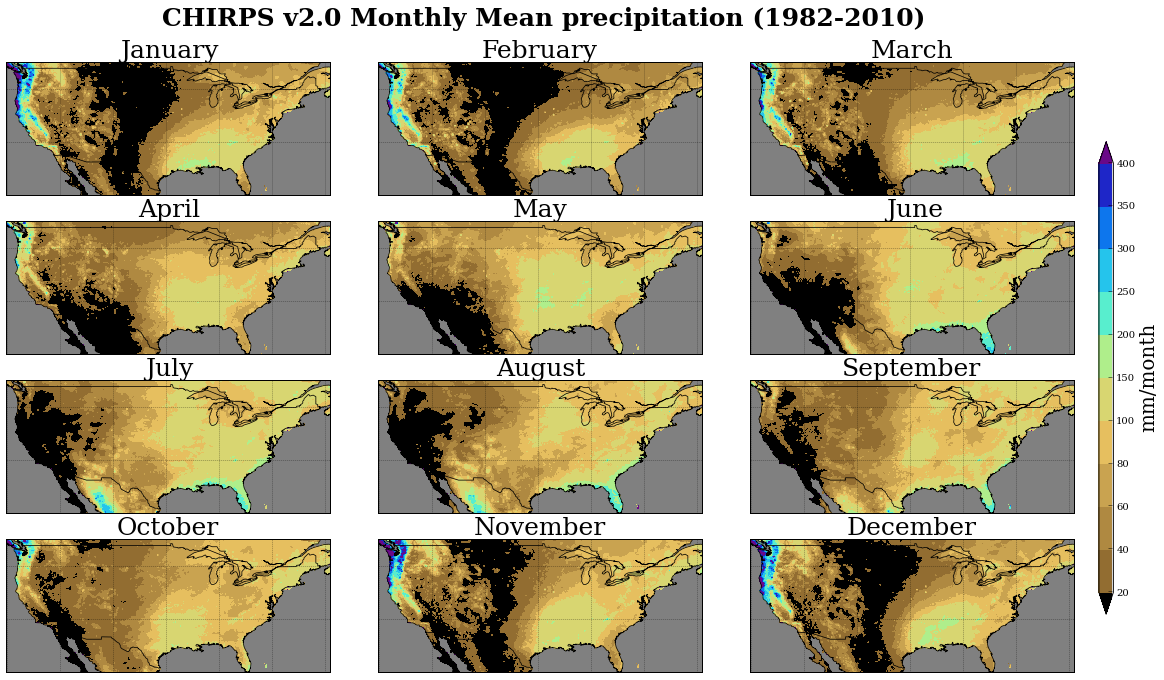

In [35]:
levels=[20, 40, 60, 80, 100, 150, 200, 250, 300, 350, 400];
NAM_boundary=[25, 50, -126, -65]
Plot_data(CHIRPS_precip_stats[0,], CHIRPS_LATS, CHIRPS_LONS, NAM_boundary, 20, cm.GMT_drywet, levels, 'CHIRPS v2.0 Monthly Mean precipitation (' + str(SYR) + '-' + str(EYR) + ')')
Figure = PLOTDIR + 'CONUS_CHIRPS_mean_precipitation_' + str(SYR) + '_' + str(EYR) + '.png'
plt.savefig(Figure, format='png', dpi=300)

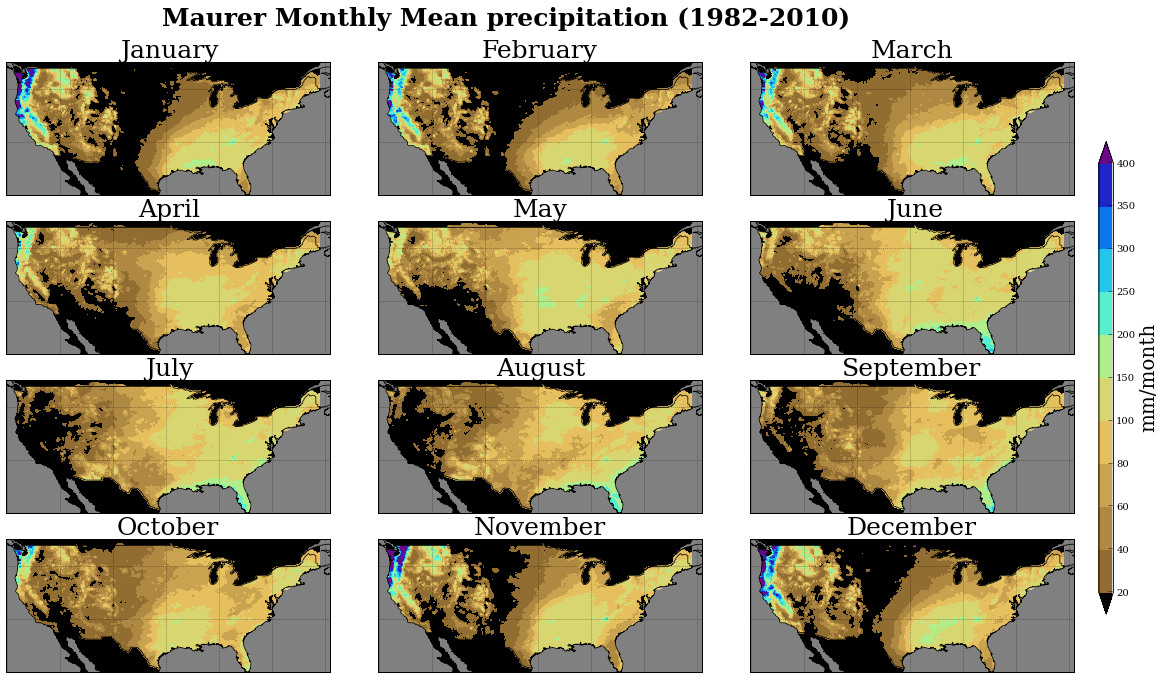

In [36]:
levels=[20, 40, 60, 80, 100, 150, 200, 250, 300, 350, 400];
NAM_boundary=[25, 50, -126, -65]
Plot_data(NAM_precip_stats[0,], NAM_LATS, NAM_LONS, NAM_boundary, 20, cm.GMT_drywet, levels, 'Maurer Monthly Mean precipitation (' + str(SYR) + '-' + str(EYR) + ')')
Figure = PLOTDIR + 'CONUS_Maurer_mean_precipitation_' + str(SYR) + '_' + str(EYR) + '.png'
plt.savefig(Figure, format='png', dpi=300)

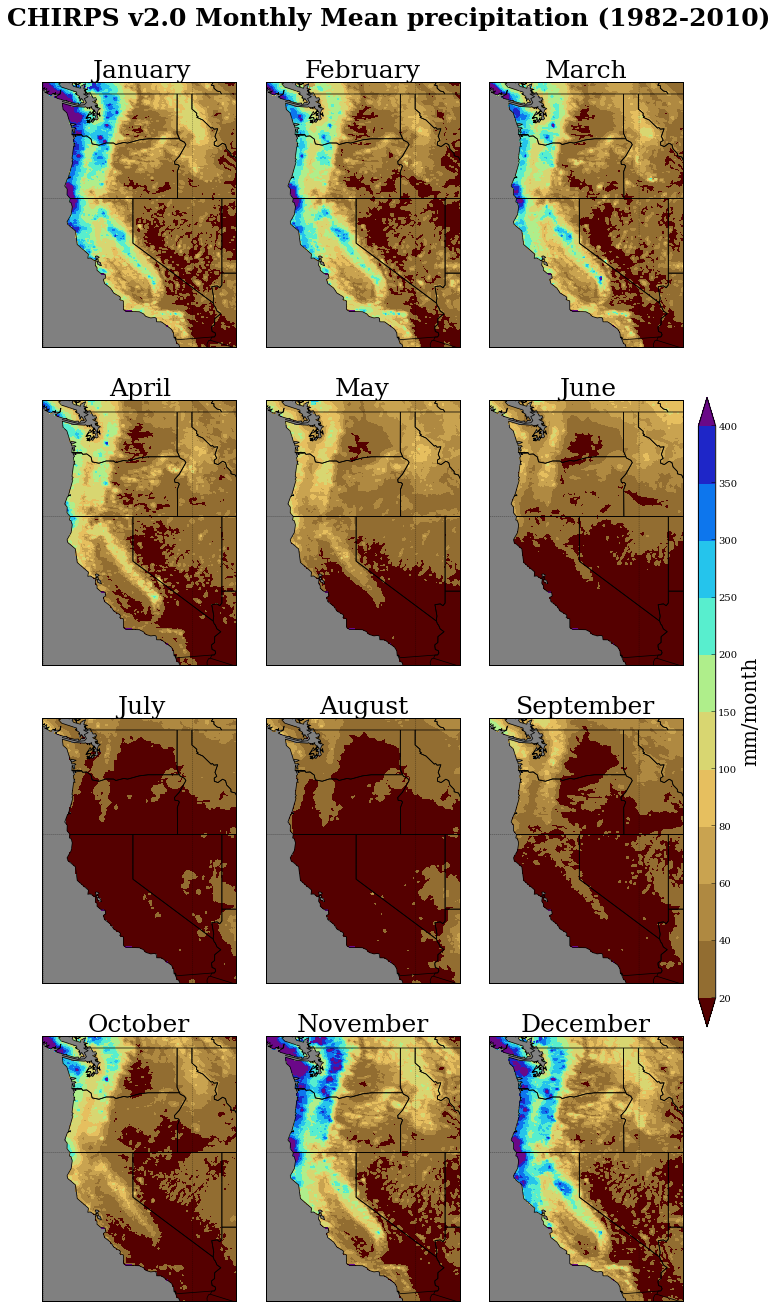

In [60]:
Boundary = [32, 49.75, -126, -113]; x_ax = -40; y_ax=1.7; cbar_axes = [0.90, 0.3, 0.02, 0.4];
DOMAIN = 'West_US'
levels=[20, 40, 60, 80, 100, 150, 200, 250, 300, 350, 400];
Plot_data(CHIRPS_precip_stats[0,], CHIRPS_LATS, CHIRPS_LONS, Boundary, 12, cm.GMT_drywet, levels, 'CHIRPS v2.0 Monthly Mean precipitation (' + str(SYR) + '-' + str(EYR) + ')', x_ax, y_ax, cbar_axes)
Figure = PLOTDIR + DOMAIN + '_CHIRPS_mean_precipitation_' + str(SYR) + '_' + str(EYR) + '.png'
plt.savefig(Figure, format='png', dpi=300)

#Plot_data(NAM_precip_stats[0,], NAM_LATS, NAM_LONS, Boundary, 12, cm.GMT_drywet, levels, 'Maurer v2.0 Monthly Mean precipitation (' + str(SYR) + '-' + str(EYR) + ')', x_ax, y_ax, cbar_axes)
#Figure = PLOTDIR + DOMAIN + '_Maurer_mean_precipitation_' + str(SYR) + '_' + str(EYR) + '.png'
#plt.savefig(Figure, format='png', dpi=300)